# Feature Reading & Cleaning

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
# read the data
df1 = pd.read_csv('data/2022.06.12.csv')
df2 = pd.read_csv('data/2022.06.13.csv')
df3 = pd.read_csv('data/2022.06.14.csv')

In [21]:
df_dataset = pd.concat([df1, df2, df3])
df_dataset.reset_index(drop=True, inplace=True)
df_dataset = df_dataset.drop(['time_start', 'time_end', 'dest_ip', 'src_ip'], axis=1)

In [22]:
# replace +ve and -ve infinity with NaN
df_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
# drop missing values
df_dataset.dropna(inplace=True)

df_dataset.drop_duplicates(inplace = True)
print(df_dataset.duplicated().sum())

0


In [23]:
df_dataset["label"].value_counts()

label
benign       434553
outlier      352045
malicious     72182
Name: count, dtype: int64

# Feature Engineering

In [24]:
df_dataset['byte_ratio'] = df_dataset['bytes_in'] / (df_dataset['bytes_out'] + 1e-9)
df_dataset['pkt_ratio'] = df_dataset['num_pkts_in'] / (df_dataset['num_pkts_out'] + 1e-9)
df_dataset['byte_pkt_in_ratio'] = df_dataset['bytes_in'] / (df_dataset['num_pkts_in'] + 1e-9)
df_dataset['byte_pkt_out_ratio'] = df_dataset['bytes_out'] / (df_dataset['num_pkts_out'] + 1e-9)
df_dataset['entropy_per_byte'] = df_dataset['entropy'] / (df_dataset['bytes_in'] + df_dataset['bytes_out'] + 1e-9)
df_dataset['total_entropy_ratio'] = df_dataset['total_entropy'] / (df_dataset['bytes_in'] + df_dataset['bytes_out'] + 1e-9)
df_dataset['is_well_known_src_port'] = df_dataset['src_port'].apply(lambda x: 1 if x < 1024 else 0)
df_dataset['is_well_known_dest_port'] = df_dataset['dest_port'].apply(lambda x: 1 if x < 1024 else 0)
df_dataset['byte_diff'] = df_dataset['bytes_in'] - df_dataset['bytes_out']
df_dataset['pkt_diff'] = df_dataset['num_pkts_in'] - df_dataset['num_pkts_out']
df_dataset['flow_efficiency'] = (df_dataset['bytes_in'] + df_dataset['bytes_out']) / (df_dataset['num_pkts_in'] + df_dataset['num_pkts_out'] + 1e-9)
df_dataset['bidirectional_entropy_ratio'] = df_dataset['entropy'] / (df_dataset['total_entropy'] + 1e-9)
df_dataset['total_bytes'] = df_dataset['bytes_in'] + df_dataset['bytes_out']
df_dataset['total_pkts'] = df_dataset['num_pkts_in'] + df_dataset['num_pkts_out']
df_dataset['avg_byte_per_pkt'] = df_dataset['total_bytes'] / (df_dataset['total_pkts'] + 1e-9)
df_dataset['log_bytes_in'] = np.log1p(df_dataset['bytes_in'])
df_dataset['log_bytes_out'] = np.log1p(df_dataset['bytes_out'])
df_dataset['log_duration'] = np.log1p(df_dataset['duration'])

proto_encoded = pd.get_dummies(df_dataset['proto'], prefix='proto')
df_dataset = pd.concat([df_dataset, proto_encoded], axis=1).drop('proto', axis=1)

# Model Training

In [25]:
df_equal = df_dataset
train, test = train_test_split(df_equal, test_size=0.2)

In [26]:
numerical_columns = ['avg_ipt', 'bytes_in', 'bytes_out', 'dest_port', 'entropy',
                     'num_pkts_out', 'num_pkts_in', 'src_port',
                    'total_entropy', 'duration']
min_max_scaler = MinMaxScaler().fit(train[numerical_columns])
train[numerical_columns] = min_max_scaler.transform(train[numerical_columns])
test[numerical_columns] = min_max_scaler.transform(test[numerical_columns])

print("Full dataset:\n")
print("Benign: " + str(df_equal["label"].value_counts()[[0]].sum()))
print("Outlier: " + str(df_equal["label"].value_counts()[[1]].sum()))
print("Malicious: " + str(df_equal["label"].value_counts()[[2]].sum()))
print("---------------")

print("Training set:\n")
print("Benign: " + str(train["label"].value_counts()[[0]].sum()))
print("Outlier: " + str(train["label"].value_counts()[[1]].sum()))
print("Malicious: " + str(train["label"].value_counts()[[2]].sum()))
print("---------------")

print("Test set:\n")
print("Benign: " + str(test["label"].value_counts()[[0]].sum()))
print("Outlier: " + str(test["label"].value_counts()[[1]].sum()))
print("Malicious: " + str(test["label"].value_counts()[[2]].sum()))

Full dataset:

Benign: 434553
Outlier: 352045
Malicious: 72182
---------------
Training set:

Benign: 347646
Outlier: 281516
Malicious: 57862
---------------
Test set:

Benign: 86907
Outlier: 70529
Malicious: 14320


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3652\3465864147.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Benign: " + str(df_equal["label"].value_counts()[[0]].sum()))
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3652\3465864147.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Outlier: " + str(df_equal["label"].value_counts()[[1]].sum()))
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3652\3465864147.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

In [27]:
y_train = np.array(train.pop("label"))
X_train = train.values

y_test = np.array(test.pop("label")) 
X_test = test.values

Perform a grid search in...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Optimal parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.9735

Model Evaluation Metrics:
Accuracy: 0.9740
F1 Score: 0.9736
Precision: 0.9735
Recall: 0.9740

5-Fold Cross-Validation Results:
Scores for each fold: [0.97331152 0.97384223 0.97387384 0.9738518  0.97265871]
Mean Score: 0.9735 (+/- 0.0009)


<Figure size 1000x800 with 0 Axes>

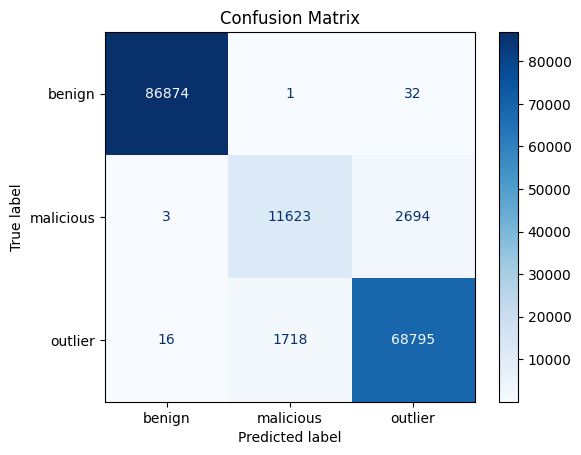


Classification Report:
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00     86907
   malicious       0.87      0.81      0.84     14320
     outlier       0.96      0.98      0.97     70529

    accuracy                           0.97    171756
   macro avg       0.94      0.93      0.94    171756
weighted avg       0.97      0.97      0.97    171756



In [28]:
# Defining the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3]
}

base_rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=base_rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='f1_weighted',
    verbose=1
)

print("Perform a grid search in...")
grid_search.fit(X_train, y_train)

print("\nOptimal parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Cross-validation
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='f1_weighted')
print("\n5-Fold Cross-Validation Results:")
print("Scores for each fold:", cv_scores)
print("Mean Score: {:.4f} (+/- {:.4f})".format(cv_scores.mean(), cv_scores.std() * 2))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_rf.classes_)
cm_display.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

